In [1]:
import os, sys
print(sys.executable) # works this time
print(sys.version)
print(sys.version_info)
import scanpy as sc
from sklearn.cross_decomposition import CCA
from sklearn.manifold import TSNE
from scipy.sparse import csr_matrix
from scipy.sparse import csr_matrix
import numpy as np
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import seaborn as sb

i:\mutiomics\pythonProject\.venv\Scripts\python.exe
3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
sys.version_info(major=3, minor=10, micro=11, releaselevel='final', serial=0)


read in data

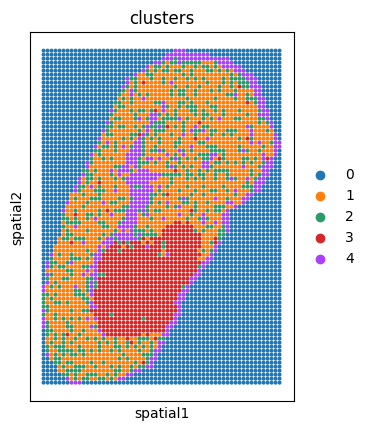

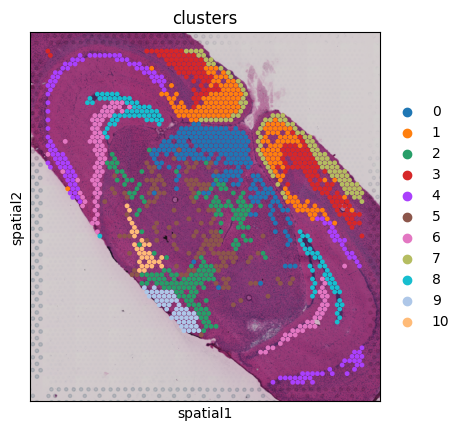

In [122]:
adata1 = sc.read_h5ad("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m4\\m4_FMP_VisiumArray.h5ad")
adata2 = sc.read_h5ad("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m4\\m4_visium_ctrl.h5ad")
sc.pl.spatial(adata1, img_key = "hires", color="clusters", spot_size=1)
sc.pl.spatial(adata2, img_key = "hires", color="clusters", size=1.5)
adata1.obs["leiden"] = adata1.obs["clusters"]
adata2.obs["leiden"] = adata2.obs["clusters"]
idx_to_remove = adata1.obs["clusters"][adata1.obs["clusters"] == "0"]
keep_cells_mask = ~adata1.obs.index.isin(idx_to_remove.index)
adata1 = adata1[keep_cells_mask, :]

using hacca to integrate

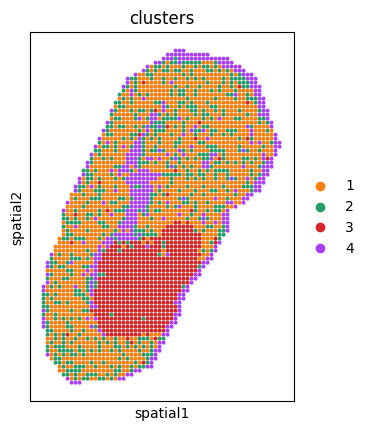

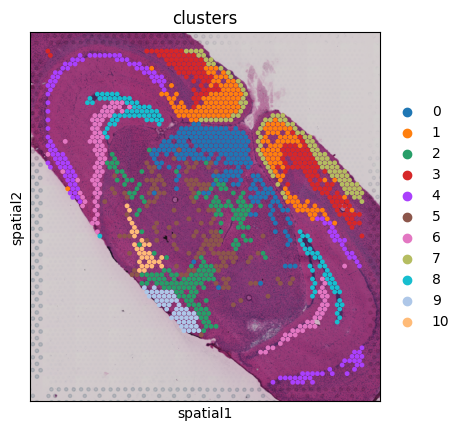

In [123]:
sc.pl.spatial(adata1, img_key = "hires", color="clusters", spot_size=1)
sc.pl.spatial(adata2, img_key = "hires", color="clusters", size=1.5)

In [124]:
import hacca
import scanpy as sc
from hacca.data import Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
b_prime_spatial = pd.DataFrame(adata2.obsm['spatial'])
scaledata = hacca.center_and_scale(b_prime_spatial)
b_prime_spatial = pd.DataFrame(scaledata, columns=b_prime_spatial.columns).to_numpy()
a_spatial = pd.DataFrame(adata1.obsm['spatial'])
scaledata = hacca.center_and_scale(a_spatial)
a_spatial = pd.DataFrame(scaledata, columns=a_spatial.columns).to_numpy()

In [125]:
a = Data(X=adata1.X.toarray(), D = a_spatial, Label=adata1.obs['leiden'].to_numpy())
b_prime = Data(X=adata2.X.toarray(), D = b_prime_spatial, Label=adata2.obs['leiden'].to_numpy())

In [126]:
#### dir name
cwd="I:\\mutiomics\\data\\pseudo_revision_2\\"
data_path = os.path.join(cwd, 'data')
work_dir = os.path.join(cwd, 'm4')
if not os.path.exists(work_dir):
    os.makedirs(work_dir)

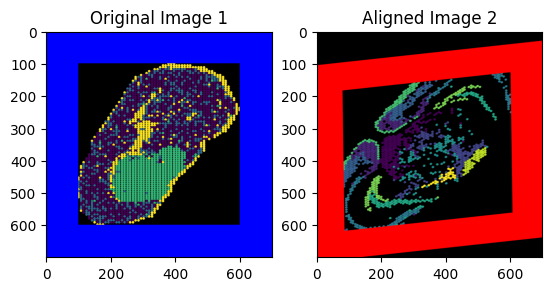

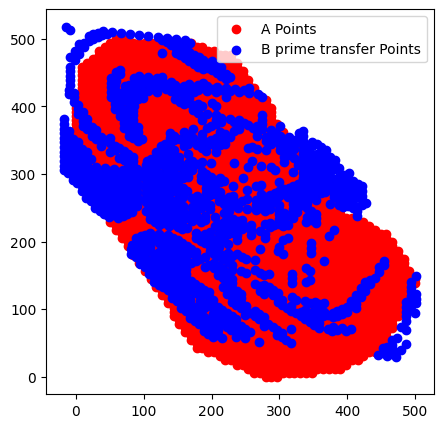

In [137]:
manual_gross_further_ICP_work_dir = os.path.join(work_dir, 'manual_gross_further')
if not os.path.exists(manual_gross_further_ICP_work_dir):
    os.makedirs(manual_gross_further_ICP_work_dir)
_b_prime = hacca.manual_gross_alignment(a, b_prime, work_dir=manual_gross_further_ICP_work_dir)

i:\mutiomics\pythonProject\hacca\alignment.py:235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_C_.loc[:,'BprimeID'] = values
i:\mutiomics\pythonProject\hacca\alignment.py:244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z_C_.loc[:,'AID'] = values
i:\mutiomics\pythonProject\hacca\alignment.py:235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

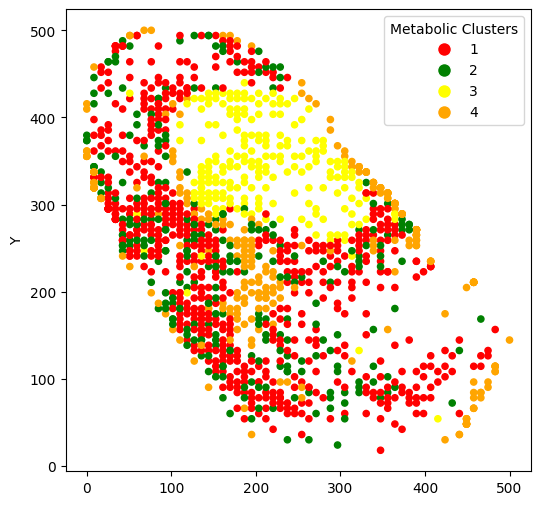

In [138]:
import gc
gc.collect()
_b_prime = hacca.further_alignment(a, _b_prime,dist_min=2)
#_a, _b_prime = hacca.icp_2d_with_feature_alignment(a, _b_prime, dist_min=2)
b_predict = hacca.direct_alignment(a, _b_prime, work_dir=manual_gross_further_ICP_work_dir)
hacca.plot_b_predict(b_predict,manual_gross_further_ICP_work_dir)

In [139]:
b_prime.X.shape
b_predict.X.shape

(1366, 1538)

In [140]:
Label_merge = np.vstack((b_prime.Label,b_predict.Label)).T
Label_merge = pd.DataFrame(Label_merge,columns=["b_prime_label","a_label"])
X_merge = np.hstack((b_prime.X,b_predict.X))
merge_var = np.hstack((adata2.var_names, adata1.var_names))
merge_var = pd.DataFrame(index=merge_var)
merge_adata = sc.AnnData(X=X_merge, var=merge_var, obs=Label_merge)
merge_adata.obsm=adata2.obsm
merge_adata.uns =adata2.uns

i:\mutiomics\pythonProject\.venv\lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


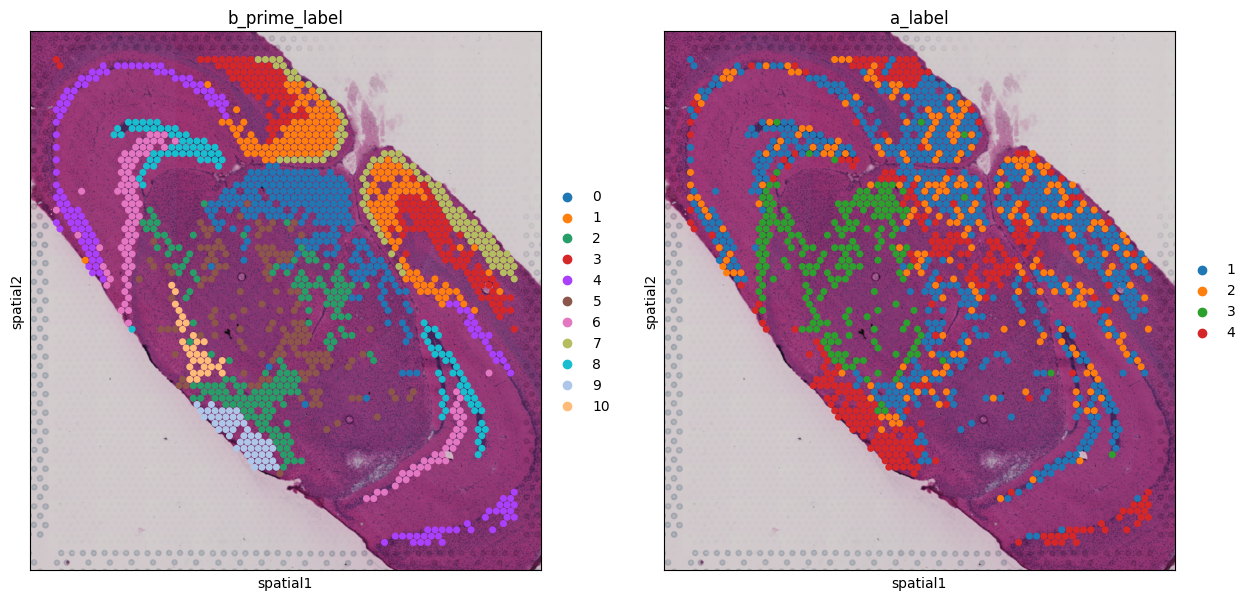

In [141]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
sc.pl.spatial(merge_adata, img_key = "hires", color="b_prime_label", size=1.5,ax=axs[0],show=False)
axs[0].set_title('b_prime_label')
sc.pl.spatial(merge_adata, img_key = "hires", color="a_label",  size=1.5,ax=axs[1],show=False)
axs[1].set_title('a_label')
plt.show()

In [142]:
os.path.join(work_dir, "merge_adata.h5ad")

'I:\\mutiomics\\data\\pseudo_revision_2\\m4\\merge_adata.h5ad'

In [143]:
merge_adata.write(os.path.join(work_dir, "merge_adata.h5ad"))

In [144]:
b_predict.X.shape
adata2.X.shape

(1366, 14442)

i:\mutiomics\pythonProject\.venv\lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


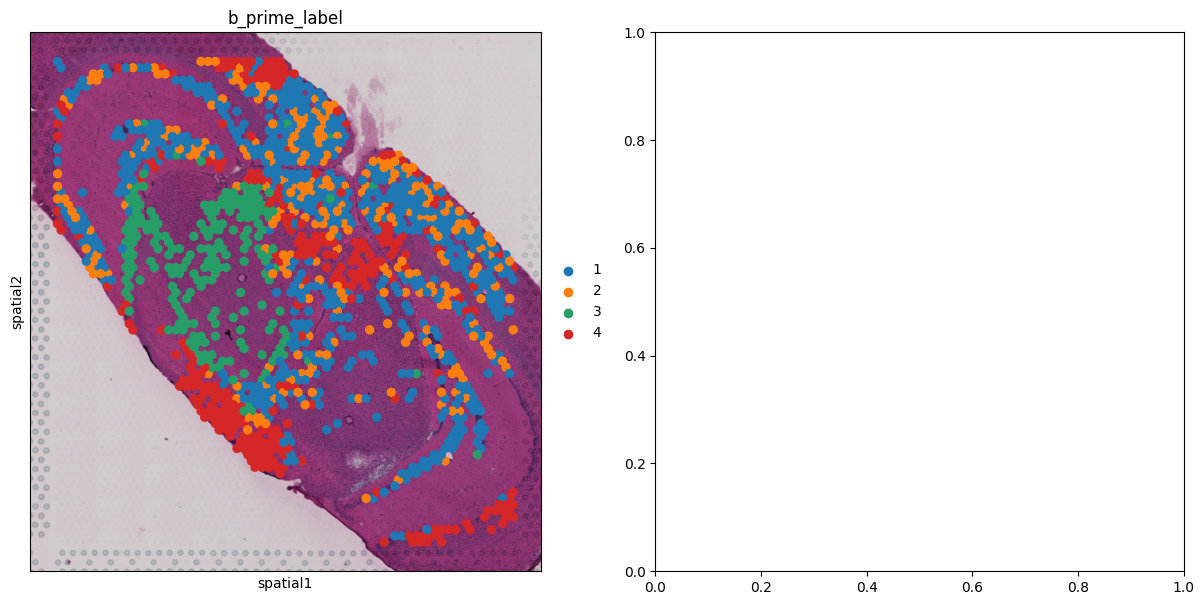

In [145]:
adata3=adata2
Label_merge= pd.DataFrame(b_predict.Label,columns=["b_prime_label"])
adata3 = sc.AnnData(X=b_predict.X, var=adata1.var, obs=Label_merge)
adata3.obsm=adata2.obsm
adata3.uns =adata2.uns

fig, axs = plt.subplots(1, 2, figsize=(15, 7))
sc.pl.spatial(adata3, img_key = "hires",color="b_prime_label", size=2,ax=axs[0],show=False)
plt.show()
adata3.write(os.path.join(work_dir, "b_predict.h5ad"))